Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'crossover_method': 'multi_point', 'adaptive_mutation': False}, Quantization Error: 0.40093
Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'crossover_method': 'multi_point', 'adaptive_mutation': True}, Quantization Error: 0.48761
Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'crossover_method': 'uniform', 'adaptive_mutation': False}, Quantization Error: 0.41151
Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'crossover_method': 'uniform', 'adaptive_mutation': True}, Quantization Error: 0.44253
Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'parent', 'crossover_method': 'multi_point', 'adaptive_mutation': False}, Quantization Error: 0.39963
Params: {'crossover_rate': 0.6, 'mutation_rate': 0.01, 'selection_method': 'parent', 'crossover_method': 'mul

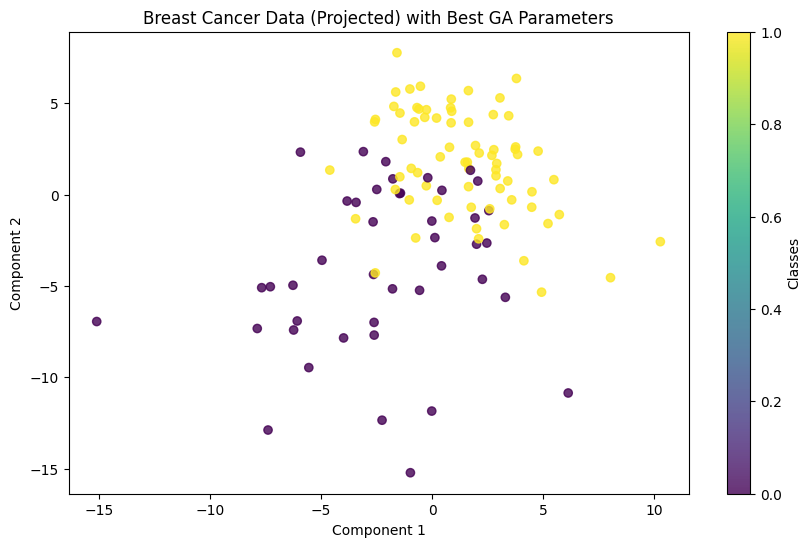

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
import itertools

class GeneticAlgorithm:
    def __init__(self, output_dim=2, pop_size=20, crossover_rate=0.8, mutation_rate=0.1, elite_size=2):
        self.output_dim = output_dim
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
        self.population = None
        self.fitness_scores = None
        self.best_solution = None
        self.best_score = float('inf')
        self.projected_data = None

    def stress(self, X, W):
        Y = X @ W
        orig_dist = np.linalg.norm(X[:, None] - X, axis=2)
        proj_dist = np.linalg.norm(Y[:, None] - Y, axis=2)
        return np.mean((orig_dist - proj_dist) ** 2)

    def initialize(self, data):
        input_dim = data.shape[1]
        self.population = []
        for _ in range(self.pop_size):
            W = np.random.randn(input_dim, self.output_dim)
            self.population.append(W)
        self.fitness_scores = [self.stress(data, ind) for ind in self.population]
        best_idx = np.argmin(self.fitness_scores)
        self.best_solution = self.population[best_idx].copy()
        self.best_score = self.fitness_scores[best_idx]

    def parent_selection(self):
        ranks = np.argsort(np.argsort(self.fitness_scores))
        max_rank = max(ranks) + 1
        probabilities = [(max_rank - rank) / sum(range(1, max_rank + 1)) for rank in ranks]
        selected_indices = np.random.choice(len(self.population), size=self.pop_size - self.elite_size, p=probabilities, replace=True)
        selected = [self.population[i].copy() for i in selected_indices]
        return list(selected)

    def selection(self):
        selected = []
        for _ in range(self.pop_size - self.elite_size):
            indices = np.random.choice(len(self.population), 3, replace=False)
            tournament = [(i, self.fitness_scores[i]) for i in indices]
            winner_idx = min(tournament, key=lambda x: x[1])[0]
            selected.append(self.population[winner_idx].copy())
        return selected

    def crossover(self, parent1, parent2, method='multi_point'):
        if method == 'multi_point':
            if np.random.rand() < self.crossover_rate:
                num_points = np.random.randint(1, parent1.shape[1])
                mask = np.zeros_like(parent1, dtype=bool)
                mask[:, np.random.choice(parent1.shape[1], num_points, replace=False)] = True
                child1 = np.where(mask, parent1, parent2)
                child2 = np.where(mask, parent2, parent1)
                return child1, child2
        elif method == 'uniform':
            mask = np.random.rand(*parent1.shape) < 0.5
            child1 = np.where(mask, parent1, parent2)
            child2 = np.where(mask, parent2, parent1)
            return child1, child2
        return parent1, parent2

    def mutate(self, individual, adaptive=False, epoch=None, max_epochs=None):
        mutation_mask = np.random.rand(*individual.shape) < self.mutation_rate
        if mutation_mask.any():
            scale = 0.1 * np.std(individual)
            if adaptive and epoch is not None and max_epochs is not None:
                scale *= (1 - (epoch / max_epochs))
            individual[mutation_mask] += np.random.normal(0, scale, size=np.sum(mutation_mask))
        return individual

    def train(self, data, epochs=30, selection_method='tournament', crossover_method='multi_point', adaptive_mutation=False):
        self.initialize(data)
        for epoch in range(epochs):
            elite_indices = np.argsort(self.fitness_scores)[:self.elite_size]
            elite = [self.population[i].copy() for i in elite_indices]
            if selection_method == 'parent':
                selected = self.parent_selection()
            else:
                selected = self.selection()
            offspring = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[(i+1) % len(selected)]
                child1, child2 = self.crossover(parent1, parent2, method=crossover_method)
                offspring.append(self.mutate(child1, adaptive=adaptive_mutation, epoch=epoch, max_epochs=epochs))
                if len(offspring) < self.pop_size - self.elite_size:
                    offspring.append(self.mutate(child2, adaptive=adaptive_mutation, epoch=epoch, max_epochs=epochs))
            self.population = elite + offspring
            self.fitness_scores = [self.stress(data, ind) for ind in self.population]
            current_best_idx = np.argmin(self.fitness_scores)
            if self.fitness_scores[current_best_idx] < self.best_score:
                self.best_score = self.fitness_scores[current_best_idx]
                self.best_solution = self.population[current_best_idx].copy()
        self.projected_data = data @ self.best_solution

    def quantization_error(self, data):
        if self.best_solution is None or self.projected_data is None:
            return float('inf')
        distances = pairwise_distances(self.projected_data)
        np.fill_diagonal(distances, np.inf)
        min_distances = np.min(distances, axis=1)
        return np.mean(min_distances)

def fine_tune_ga(X_train, param_grid, epochs=30):
    best_params = None
    best_error = float('inf')
    for params in param_grid:
        ga = GeneticAlgorithm(
            output_dim=2,
            pop_size=20,
            crossover_rate=params['crossover_rate'],
            mutation_rate=params['mutation_rate'],
            elite_size=2
        )
        ga.train(
            X_train,
            epochs=epochs,
            selection_method=params['selection_method'],
            crossover_method=params['crossover_method'],
            adaptive_mutation=params['adaptive_mutation']
        )
        q_error = ga.quantization_error(X_train)
        print(f"Params: {params}, Quantization Error: {q_error:.5f}")
        if q_error < best_error:
            best_error = q_error
            best_params = params
            best_solution = ga.best_solution.copy()
    return best_params, best_error, best_solution

# Load data and preprocess
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define grid of parameters for fine tuning
param_grid = []
crossover_rates = [0.6, 0.8, 1.0]
mutation_rates = [0.01, 0.05, 0.1, 0.2]
selection_methods = ['tournament', 'parent']
crossover_methods = ['multi_point', 'uniform']
adaptive_options = [False, True]

for cr, mr, sm, cm, am in itertools.product(crossover_rates, mutation_rates, selection_methods, crossover_methods, adaptive_options):
    param_grid.append({
        'crossover_rate': cr,
        'mutation_rate': mr,
        'selection_method': sm,
        'crossover_method': cm,
        'adaptive_mutation': am
    })

# Run fine tuning
best_params, best_error, best_solution = fine_tune_ga(X_train, param_grid, epochs=30)
print(f"\nBest Parameters: {best_params}")
print(f"Best Quantization Error: {best_error}")

# Visualize the best solution on test set
ga = GeneticAlgorithm(output_dim=2, pop_size=20,
                      crossover_rate=best_params['crossover_rate'],
                      mutation_rate=best_params['mutation_rate'],
                      elite_size=2)
ga.best_solution = best_solution
ga.projected_data = X_test @ best_solution

plt.figure(figsize=(10, 6))
plt.scatter(ga.projected_data[:, 0], ga.projected_data[:, 1], c=y_test, cmap='viridis', alpha=0.8)
plt.title("Breast Cancer Data (Projected) with Best GA Parameters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Classes')
plt.show()